In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
def preprocess_fit(df: pd.DataFrame):
    keep_cols = [
        'age', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
        'skill_moves', 'weak_foot', 'player_positions', 'value_eur'
    ]
    df_proc = df[df.value_eur!=0][keep_cols].copy()
    y = np.log(df_proc['value_eur'])
    df_proc = df_proc.drop(columns=['value_eur'])
    df_proc['primary_position'] = df_proc['player_positions'].astype(str).str.split(',').str[0].str.strip()
    positions = ['ST', 'CF', 'LW', 'RW', 'CAM', 'CM', 'CDM', 'LM', 'RM', 'CB', 'LB', 'RB', 'LWB', 'RWB', 'GK']
    ohe = OneHotEncoder(categories=[positions], handle_unknown='ignore', sparse_output=False)
    pos_ohe_array = ohe.fit_transform(df_proc[['primary_position']])
    pos_ohe = pd.DataFrame(pos_ohe_array, columns=positions, index=df_proc.index)
    df_proc = df_proc.drop(columns=['player_positions', 'primary_position'])
    numeric_cols = df_proc.columns
    mm = MinMaxScaler()
    scaled_values = mm.fit_transform(df_proc[numeric_cols])
    scaled_numeric = pd.DataFrame(scaled_values, columns=numeric_cols, index=df_proc.index)
    scaled_numeric.fillna(scaled_numeric.mean(), inplace=True)
    X = pd.concat([pos_ohe, scaled_numeric], axis=1)
    return X, y, mm, ohe


def preprocess_trans(df: pd.DataFrame, mm: MinMaxScaler, ohe: OneHotEncoder):
    keep_cols = [
        'age', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
        'skill_moves', 'weak_foot', 'player_positions'
    ]
    df_proc = df[keep_cols].copy()

    df_proc['primary_position'] = df_proc['player_positions'].astype(str).str.split(',').str[0].str.strip()

    positions = ['ST', 'CF', 'LW', 'RW', 'CAM', 'CM', 'CDM', 'LM', 'RM', 'CB', 'LB', 'RB', 'LWB', 'RWB', 'GK']
    pos_ohe_array = ohe.transform(df_proc[['primary_position']])
    pos_ohe = pd.DataFrame(pos_ohe_array, columns=positions, index=df_proc.index)

    df_proc = df_proc.drop(columns=['player_positions', 'primary_position'])

    numeric_cols = df_proc.columns
    scaled_values = mm.transform(df_proc[numeric_cols])
    scaled_numeric = pd.DataFrame(scaled_values, columns=numeric_cols, index=df_proc.index)

    scaled_numeric.fillna(scaled_numeric.mean(), inplace=True)

    X = pd.concat([pos_ohe, scaled_numeric], axis=1)

    return X


In [122]:
x, y, m, h = preprocess_fit(pd.read_csv('../raw_data/FC26_20250921.csv', low_memory=False))

In [123]:
from matplotlib import pyplot as plt
%matplotlib inline

(array([  11.,  116., 1006., 3277., 6214., 4880., 1617.,  777.,  343.,
          55.]),
 array([ 9.10497986, 10.0922254 , 11.07947094, 12.06671649, 13.05396203,
        14.04120758, 15.02845312, 16.01569867, 17.00294421, 17.99018976,
        18.9774353 ]),
 <BarContainer object of 10 artists>)

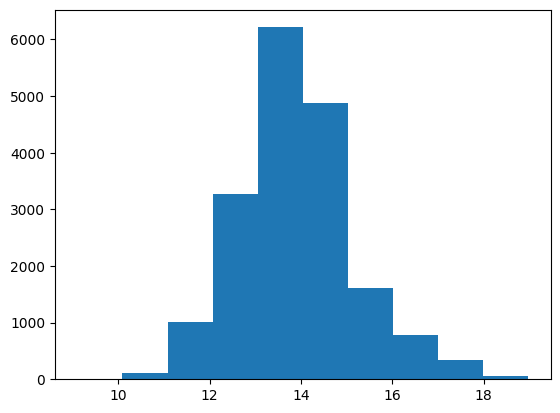

In [124]:
import numpy as np
plt.hist(y)

In [126]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=200, random_state=42)
xtrain, xtest, ytrain, ytest = train_test_split(x, y)
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)
mae = mean_absolute_error(ytest, ypred)
mse = mean_squared_error(ytest, ypred)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, ypred)
print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score, of test against pred: {r2:.4f}")

train_r2 = model.score(xtrain, ytrain)
test_r2  = model.score(xtest, ytest)
print(f"Train R²: {train_r2:.4f}")
print(f"Test  R²: {test_r2:.4f}")

Model Performance:
Mean Absolute Error (MAE): 0.29
Mean Squared Error (MSE): 0.24
Root Mean Squared Error (RMSE): 0.49
R² Score, of test against pred: 0.8536
Train R²: 0.8983
Test  R²: 0.8536


In [127]:
def forest_test(raw_data):
    x, y, m, h = preprocess_fit(raw_data)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    xtrain, xtest, ytrain, ytest = train_test_split(x, y)
    model.fit(xtrain, ytrain)
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    train_r2 = model.score(xtrain, ytrain)
    test_r2 = model.score(xtest, ytest)
    ypred = model.predict(xtest)
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    rmse = np.sqrt(mse)

    exclude_positions = ['GK', 'LWB', 'RWB']
    exclude_mask = ~xtest[exclude_positions].any(axis=1)
    xtest_filtered = xtest[exclude_mask]
    ytest_filtered = ytest[exclude_mask]

    if len(xtest_filtered) > 0:
        ypred_filtered = model.predict(xtest_filtered)
        r2_filtered = r2_score(ytest_filtered, ypred_filtered)
        filtered_count = len(xtest_filtered)
    else:
        r2_filtered = None
        filtered_count = 0

    print("=" * 70)
    print("MODEL PERFORMANCE REPORT")
    print("=" * 70)
    print("\nOVERALL METRICS:")
    print("-" * 70)
    print(f"  Train R²:                    {train_r2:.4f}")
    print(f"  Test R²:                     {test_r2:.4f}")
    print(f"  Mean Absolute Error (MAE):   {mae:.4f}")
    print(f"  Mean Squared Error (MSE):    {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")

    if r2_filtered is not None:
        print(f"\n  Test R² (excluding GK/LWB/RWB): {r2_filtered:.4f} (n={filtered_count})")
    else:
        print(f"\n  Test R² (excluding GK/LWB/RWB): N/A (no samples)")

    positions = ['ST', 'CF', 'LW', 'RW', 'CAM', 'CM', 'CDM', 'LM', 'RM', 'CB', 'LB', 'RB', 'LWB', 'RWB', 'GK']

    print("\n" + "=" * 70)
    print("POSITION-SPECIFIC TEST R² SCORES:")
    print("=" * 70)
    print(f"{'Position':<10} {'Count':<10} {'Test R²':<15} {'Performance'}")
    print("-" * 70)

    position_results = []
    for pos in positions:
        pos_mask = xtest[pos] == 1
        pos_count = pos_mask.sum()
        if pos_count > 0:
            xtest_pos = xtest[pos_mask]
            ytest_pos = ytest[pos_mask]
            ypred_pos = model.predict(xtest_pos)
            pos_r2 = r2_score(ytest_pos, ypred_pos)
            
            if pos_r2 >= 0.85:
                perf = "Excellent"
            elif pos_r2 >= 0.75:
                perf = "Good"
            elif pos_r2 >= 0.60:
                perf = "Fair"
            else:
                perf = "Needs Improvement"
            
            position_results.append((pos, pos_count, pos_r2, perf))
            print(f"{pos:<10} {pos_count:<10} {pos_r2:<15.4f} {perf}")
        else:
            print(f"{pos:<10} {pos_count:<10} {'N/A':<15} No test samples")
    print("=" * 70)
    if position_results:
        r2_values = [r[2] for r in position_results]
        print(f"\nPOSITION R² SUMMARY:")
        print(f"  Best Position:  {max(position_results, key=lambda x: x[2])[0]} (R² = {max(r2_values):.4f})")
        print(f"  Worst Position: {min(position_results, key=lambda x: x[2])[0]} (R² = {min(r2_values):.4f})")
        print(f"  Average R²:     {np.mean(r2_values):.4f}")
        print(f"  Std Dev R²:     {np.std(r2_values):.4f}")
    
    print("=" * 70)

    print("\n" + "=" * 70)
    print("MODEL TRAINED WITHOUT GK DATA:")
    print("=" * 70)

    train_no_gk_mask = xtrain['GK'] == 0
    test_no_gk_mask = xtest['GK'] == 0
    
    xtrain_no_gk = xtrain[train_no_gk_mask]
    ytrain_no_gk = ytrain[train_no_gk_mask]
    xtest_no_gk = xtest[test_no_gk_mask]
    ytest_no_gk = ytest[test_no_gk_mask]
    
    if len(xtrain_no_gk) > 0 and len(xtest_no_gk) > 0:
        model_no_gk = RandomForestRegressor(n_estimators=200, random_state=42)
        model_no_gk.fit(xtrain_no_gk, ytrain_no_gk)

        train_r2_no_gk = model_no_gk.score(xtrain_no_gk, ytrain_no_gk)
        test_r2_no_gk = model_no_gk.score(xtest_no_gk, ytest_no_gk)
        ypred_no_gk = model_no_gk.predict(xtest_no_gk)
        mae_no_gk = mean_absolute_error(ytest_no_gk, ypred_no_gk)
        mse_no_gk = mean_squared_error(ytest_no_gk, ypred_no_gk)
        rmse_no_gk = np.sqrt(mse_no_gk)
        
        print(f"  Training samples (no GK):    {len(xtrain_no_gk)}")
        print(f"  Test samples (no GK):        {len(xtest_no_gk)}")
        print("-" * 70)
        print(f"  Train R²:                    {train_r2_no_gk:.4f}")
        print(f"  Test R²:                     {test_r2_no_gk:.4f}")
        print(f"  Mean Absolute Error (MAE):   {mae_no_gk:.4f}")
        print(f"  Mean Squared Error (MSE):    {mse_no_gk:.4f}")
        print(f"  Root Mean Squared Error (RMSE): {rmse_no_gk:.4f}")
        print("-" * 70)
        print(f"  Improvement in Test R²:      {test_r2_no_gk - test_r2:+.4f}")
        print(f"  Improvement in MAE:          {mae - mae_no_gk:+.4f}")
    else:
        print("  Insufficient data to train model without GK")
    
    print("=" * 70)

    print("\n" + "=" * 70)
    print("FEATURE IMPORTANCE: MODEL WITHOUT POSITION DATA")
    print("=" * 70)
    print("\nTraining model on outfield players WITHOUT position features")
    print("to verify the importance of position information...")
    print()

    train_no_gk_mask = xtrain['GK'] == 0
    test_no_gk_mask = xtest['GK'] == 0

    xtrain_no_gk_full = xtrain[train_no_gk_mask]
    ytrain_no_gk_full = ytrain[train_no_gk_mask]
    xtest_no_gk_full = xtest[test_no_gk_mask]
    ytest_no_gk_full = ytest[test_no_gk_mask]

    position_cols = ['ST', 'CF', 'LW', 'RW', 'CAM', 'CM', 'CDM', 'LM', 'RM', 'CB', 'LB', 'RB', 'LWB', 'RWB', 'GK']
    xtrain_no_pos = xtrain_no_gk_full.drop(columns=position_cols)
    xtest_no_pos = xtest_no_gk_full.drop(columns=position_cols)
    
    if len(xtrain_no_pos) > 0 and len(xtest_no_pos) > 0:
        model_no_pos = RandomForestRegressor(n_estimators=200, random_state=42)
        model_no_pos.fit(xtrain_no_pos, ytrain_no_gk_full)
        
        train_r2_no_pos = model_no_pos.score(xtrain_no_pos, ytrain_no_gk_full)
        test_r2_no_pos = model_no_pos.score(xtest_no_pos, ytest_no_gk_full)
        
        print(f"  Training samples:            {len(xtrain_no_pos)}")
        print(f"  Test samples:                {len(xtest_no_pos)}")
        print(f"  Features used:               {list(xtrain_no_pos.columns)}")
        print("-" * 70)
        print(f"  Train R² (no position):      {train_r2_no_pos:.4f}")
        print(f"  Test R² (no position):       {test_r2_no_pos:.4f}")
        print("-" * 70)
        print(f"  Model WITH position (ref):   {test_r2_no_gk:.4f}")
        print(f"  Model WITHOUT position:      {test_r2_no_pos:.4f}")
        print(f"  Performance loss:            {test_r2_no_gk - test_r2_no_pos:.4f}")
        print(f"  Relative loss:               {((test_r2_no_gk - test_r2_no_pos) / test_r2_no_gk * 100):.2f}%")
        print("-" * 70)
        
        if test_r2_no_pos < test_r2_no_gk:
            print(f"  Conclusion: Position information is IMPORTANT")
            print(f"              Removing position features causes performance degradation")
        else:
            print(f"  Conclusion: Position information has MINIMAL impact")
            print(f"              Model performs similarly without position features")
    else:
        print("  Insufficient data for analysis")
    
    print("=" * 70)

In [128]:
forest_test(pd.read_csv('../raw_data/FC26_20250921.csv', low_memory=False))

MODEL PERFORMANCE REPORT

OVERALL METRICS:
----------------------------------------------------------------------
  Train R²:                    0.8993
  Test R²:                     0.8523
  Mean Absolute Error (MAE):   0.2852
  Mean Squared Error (MSE):    0.2334
  Root Mean Squared Error (RMSE): 0.4831

  Test R² (excluding GK/LWB/RWB): 0.9524 (n=4068)

POSITION-SPECIFIC TEST R² SCORES:
Position   Count      Test R²         Performance
----------------------------------------------------------------------
ST         638        0.9479          Excellent
CF         0          N/A             No test samples
LW         107        0.9644          Excellent
RW         107        0.9722          Excellent
CAM        279        0.9481          Excellent
CM         551        0.9438          Excellent
CDM        334        0.9483          Excellent
LM         259        0.9520          Excellent
RM         253        0.9520          Excellent
CB         853        0.9643          Excellent


In [129]:

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


x_no_gk = x[x['GK'] == 0]
y_no_gk = y[x['GK'] == 0]

xtrain_mlp, xtest_mlp, ytrain_mlp, ytest_mlp = train_test_split(x_no_gk, y_no_gk, random_state=42)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)

print("Training 3-Layer MLP...")
print(f"Architecture: Input({xtrain_mlp.shape[1]}) -> Hidden(128) -> Hidden(64) -> Hidden(32) -> Output(1)")
print(f"Training samples: {len(xtrain_mlp)}, Test samples: {len(xtest_mlp)}")
print("-" * 70)

mlp_model.fit(xtrain_mlp, ytrain_mlp)

print("\n" + "=" * 70)
print("MLP MODEL PERFORMANCE")
print("=" * 70)

train_r2_mlp = mlp_model.score(xtrain_mlp, ytrain_mlp)
test_r2_mlp = mlp_model.score(xtest_mlp, ytest_mlp)

ypred_mlp = mlp_model.predict(xtest_mlp)
mae_mlp = mean_absolute_error(ytest_mlp, ypred_mlp)
mse_mlp = mean_squared_error(ytest_mlp, ypred_mlp)
rmse_mlp = np.sqrt(mse_mlp)

print(f"\nTrain R²:                    {train_r2_mlp:.4f}")
print(f"Test R²:                     {test_r2_mlp:.4f}")
print(f"Mean Absolute Error (MAE):   {mae_mlp:.4f}")
print(f"Mean Squared Error (MSE):    {mse_mlp:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_mlp:.4f}")
print(f"\nNumber of iterations:        {mlp_model.n_iter_}")
print(f"Training loss:               {mlp_model.loss_:.4f}")

print("=" * 70)

Training 3-Layer MLP...
Architecture: Input(24) -> Hidden(128) -> Hidden(64) -> Hidden(32) -> Output(1)
Training samples: 12184, Test samples: 4062
----------------------------------------------------------------------

MLP MODEL PERFORMANCE

Train R²:                    0.9649
Test R²:                     0.9641
Mean Absolute Error (MAE):   0.1864
Mean Squared Error (MSE):    0.0561
Root Mean Squared Error (RMSE): 0.2369

Number of iterations:        174
Training loss:               0.0277


In [130]:
random_forest_model = RandomForestRegressor(n_estimators=200, random_state=42)
xtrain, xtest, ytrain, ytest = train_test_split(x_no_gk, y_no_gk)
random_forest_model.fit(xtrain, ytrain)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [131]:

print("=" * 70)
print("MODEL COMPARISON: MLP vs Random Forest")
print("=" * 70)

rf_model_compare = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model_compare.fit(xtrain_mlp, ytrain_mlp)

train_r2_rf = rf_model_compare.score(xtrain_mlp, ytrain_mlp)
test_r2_rf = rf_model_compare.score(xtest_mlp, ytest_mlp)

ypred_rf = rf_model_compare.predict(xtest_mlp)
mae_rf = mean_absolute_error(ytest_mlp, ypred_rf)
mse_rf = mean_squared_error(ytest_mlp, ypred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"\n{'Metric':<30} {'Random Forest':<20} {'MLP':<20} {'Winner'}")
print("-" * 70)
print(f"{'Train R²':<30} {train_r2_rf:<20.4f} {train_r2_mlp:<20.4f} {'RF' if train_r2_rf > train_r2_mlp else 'MLP'}")
print(f"{'Test R²':<30} {test_r2_rf:<20.4f} {test_r2_mlp:<20.4f} {'RF' if test_r2_rf > test_r2_mlp else 'MLP'}")
print(f"{'MAE (lower is better)':<30} {mae_rf:<20.4f} {mae_mlp:<20.4f} {'RF' if mae_rf < mae_mlp else 'MLP'}")
print(f"{'MSE (lower is better)':<30} {mse_rf:<20.4f} {mse_mlp:<20.4f} {'RF' if mse_rf < mse_mlp else 'MLP'}")
print(f"{'RMSE (lower is better)':<30} {rmse_rf:<20.4f} {rmse_mlp:<20.4f} {'RF' if rmse_rf < rmse_mlp else 'MLP'}")
print("-" * 70)

rf_wins = sum([
    test_r2_rf > test_r2_mlp,
    mae_rf < mae_mlp,
    mse_rf < mse_mlp,
    rmse_rf < rmse_mlp
])

mlp_wins = 4 - rf_wins

print(f"\nOverall: Random Forest wins {rf_wins}/4 metrics, MLP wins {mlp_wins}/4 metrics")

if test_r2_rf > test_r2_mlp:
    print(f"Random Forest achieves better Test R² by {test_r2_rf - test_r2_mlp:.4f}")
else:
    print(f"MLP achieves better Test R² by {test_r2_mlp - test_r2_rf:.4f}")

print("=" * 70)

MODEL COMPARISON: MLP vs Random Forest

Metric                         Random Forest        MLP                  Winner
----------------------------------------------------------------------
Train R²                       0.9933               0.9649               RF
Test R²                        0.9542               0.9641               MLP
MAE (lower is better)          0.2047               0.1864               MLP
MSE (lower is better)          0.0716               0.0561               MLP
RMSE (lower is better)         0.2676               0.2369               MLP
----------------------------------------------------------------------

Overall: Random Forest wins 0/4 metrics, MLP wins 4/4 metrics
MLP achieves better Test R² by 0.0099


In [132]:
(mlp_model.predict(x_no_gk) - y_no_gk).describe()

count    16246.000000
mean         0.002205
std          0.232376
min         -1.296915
25%         -0.147515
50%         -0.000469
75%          0.155631
max          1.044674
Name: value_eur, dtype: float64

In [133]:
(np.exp(mlp_model.predict(x_no_gk)) - np.exp(y_no_gk)).describe()

count    1.624600e+04
mean    -8.321428e+03
std      2.858254e+06
min     -4.404810e+07
25%     -1.397935e+05
50%     -1.769716e+02
75%      1.441324e+05
max      1.568876e+08
Name: value_eur, dtype: float64

In [134]:
(random_forest_model.predict(x_no_gk) - y_no_gk).describe()

count    16246.000000
mean         0.001626
std          0.162393
min         -1.384730
25%         -0.075078
50%         -0.002307
75%          0.073057
max          1.572036
Name: value_eur, dtype: float64

In [135]:
(np.exp(random_forest_model.predict(x_no_gk)) - np.exp(y_no_gk)).describe()

count    1.624600e+04
mean    -1.698516e+05
std      1.888764e+06
min     -1.108315e+08
25%     -9.125834e+04
50%     -1.641950e+03
75%      5.771874e+04
max      2.447889e+07
Name: value_eur, dtype: float64